  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
# import csv
# import json
# import time
# import types
# import copy
import json
import os
import random
import sys
from typing import List, Tuple
from types import SimpleNamespace
import yaml
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# from hydra import initialize, initialize_config_module, initialize_config_dir, compose
# from omegaconf import OmegaConf
# from typing import Dict, List, Tuple
# from scipy.sparse import csr_matrix
# from tqdm import tqdm
 
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=180, profile=None, sci_mode=None)
torch.manual_seed(42); # seed rng for reproducibility
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [3]:
# import snnl.utils as utils
from utils.utils_ptsnnl import display_cellpainting_batch
from utils.utils_cellpainting import label_counts, balance_datasets
from utils.dataloader import custom_collate_fn,CellpaintingDataset, InfiniteDataLoader
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle
from utils.utils_cellpainting import save_checkpoint


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
import scipy
import scipy.stats as sps
import sklearn.metrics as skm
from scipy.spatial.distance import pdist, squareform, euclidean


# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
# from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder, StandardScaler

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
RUN_DATETIME = datetime.now().strftime('%Y%m%d_%H%M')
logging.basicConfig(level="INFO", format= FORMAT)
logger.info(f" Excution started : {RUN_DATETIME} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-08-27 00:59:44,850 - __main__ - INFO: -  Excution started : 20240827_0059 
2024-08-27 00:59:44,851 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-08-27 00:59:44,852 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-08-27 00:59:44,852 - __main__ - INFO: -  Pandas version: 2.2.0  


## Helper routines

In [6]:
# def compute_classification_metrics(mo):
#     """
#     mo : model outpust from 'run_model_on_test_data'
#     """
#     cm = SimpleNamespace()
 
#     cm.accuracy = skm.accuracy_score(mo.y_true, mo.y_pred)
#     cm.roc_auc  = skm.roc_auc_score(mo.y_true, mo.y_logits)
#     cm.precision, cm.recall, cm.f1, _ = skm.precision_recall_fscore_support(mo.y_true, mo.y_pred, average='binary', zero_division=0)
#     cm.cls_report = skm.classification_report(mo.y_true, mo.y_pred)
#     (mo.y_true == mo.y_pred).sum()
    
#     # cm.test_accuracy = binary_accuracy(y_true=mo.labels, y_prob=mo.logits)
#     # cm.test_f1 = binary_f1_score(y_true=mo.labels, y_prob=mo.logits)
#     return cm


In [7]:
### from sklearn.metrics import RocCurveDisplay
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
def plot_cls_metrics(y_true, y_prob, y_pred, epochs = None ):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    msg_sfx = f"- epoch:{epochs} " if epochs is not None else ""
    roc_display = skm.RocCurveDisplay.from_predictions(
        y_true.squeeze(),
        y_prob.squeeze(), 
        name=f"ROC Curve",
        color="darkorange",
        plot_chance_level=True,
        ax = axes[0])

    _ = roc_display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title = f" ROC curve {msg_sfx}")
        # title=f"ROC curve - TPSA Classification  \n LogLoss: {metrics['logloss'] :0.3f} AUC: {metrics['roc_auc']:0.3f} ",
    _ = roc_display.ax_.legend(fontsize=8)

    pr_display = skm.PrecisionRecallDisplay.from_predictions(
        y_true.squeeze(),
        y_prob.squeeze(),
        name="Precision/Recall",
        pos_label= 1,
        plot_chance_level=True,
        ax = axes[1])

    _ = pr_display.ax_.set_title(f" Precision-Recall curve {msg_sfx}")
    _ = pr_display.ax_.legend(fontsize=8)


    cm_display = skm.ConfusionMatrixDisplay.from_predictions(
        y_true.squeeze(),
        y_pred.squeeze(),
        values_format="5d",
        ax = axes[2])

    _ = cm_display.ax_.set_title(f"Confusion Matrix {msg_sfx}")


In [8]:
def compute_classification_metrics(mo, verbose = False):
    """
    mo : model outpust from 'run_model_on_test_data'
    """
    cm = SimpleNamespace()
 
    cm.accuracy = skm.accuracy_score(mo.y_true, mo.y_pred) * 100.0
    cm.roc_auc  = skm.roc_auc_score(mo.y_true, mo.y_logits)
    cm.precision, cm.recall, cm.f1, _ = skm.precision_recall_fscore_support(mo.y_true, mo.y_pred, average='binary', zero_division=0)
    cm.cls_report = skm.classification_report(mo.y_true, mo.y_pred)
    (mo.y_true == mo.y_pred).sum()
    
    # cm.test_accuracy = binary_accuracy(y_true=mo.labels, y_prob=mo.logits)
    # cm.test_f1 = binary_f1_score(y_true=mo.labels, y_prob=mo.logits)
    if verbose: 
        print(f" accuracy :   {cm.accuracy:.2f} %")
        print(f" roc_auc  :   {cm.roc_auc:.6f} ")
        print(f" precision:   {cm.precision:.6f}   \n recall   :   {cm.recall:.6f}    \n f1       :   {cm.f1:.6f}")
        print("\n Classification Report: \n")
        print(cm.cls_report)
        (mo.y_true == mo.y_pred).sum()
        print(np.bincount(mo.y_pred.squeeze()))
    return cm


In [9]:
def run_model_on_test_data(model, data_loader, device, verbose = False):
    """
    embedding layer: layer that contains embedding (for encoding models)
    """
    out = SimpleNamespace()
    out.tpsa = np.empty((0,3))
    # out.logits = np.empty((0))
    out.compounds = np.empty((0))
    out.embeddings = {} 

    out.y_true = np.empty((0,1), dtype=np.uint8)
    out.y_logits = np.empty((0,1))
    out.y_prob = np.empty((0,1))
    out.y_pred = np.empty((0,1), dtype=np.uint8)
    # out.labels = np.empty((0,1))
    
    model.eval()
    
    for idx, (batch_features, batch_labels, batch_wellinfo , batch_compound_ids, batch_hashbin, batch_tpsa) in enumerate(data_loader):
        #    (batch_features, batch_labels, plate_well, compound, hash) 
        batch_features = batch_features.to(device)
        batch_labels   = batch_labels.to(device)
        batch_logits = model(batch_features)
        # print(f" batchtpsa : {batch_tpsa.shape}  \n {batch_tpsa[:3,:]}")
        # print(f" batchlabels: {batch_labels.shape}  batch_output: {batch_output.shape}    batch_features: {batch_features.shape}")            
        out.compounds = np.concatenate((out.compounds, batch_compound_ids))    
        out.y_true = np.concatenate((out.y_true, batch_labels.detach().cpu().numpy().astype(np.uint8)))
        out.y_logits = np.concatenate((out.y_logits, batch_logits.detach().cpu().numpy()))
        out.y_prob = np.concatenate((out.y_prob, torch.sigmoid(batch_logits).detach().cpu().numpy())) 
        
        # out.labels = np.concatenate((out.labels, batch_labels.detach().cpu().numpy()))
        out.tpsa   = np.concatenate((out.tpsa ,  batch_tpsa))
        if verbose:
            print(f" output :  {idx:2d} - Labels:{out.y_true.shape[0]:5d}   y_true:{out.y_true.shape}   y_pred:{out.y_pred.shape} ")
    ###- end
    
    out.y_true = out.y_true.squeeze()
    out.y_logits = out.y_logits.squeeze()
    out.y_prob = out.y_prob.squeeze()
    out.y_pred = np.round(out.y_prob).astype(np.uint8)
    out.comp_labels = np.arange(out.y_true.shape[0],dtype=np.int16)//3 
    if verbose:
        print(f" out.y_true     :  {out.y_true.dtype}  shape: {out.y_true.shape} sum: {out.y_true.sum()} - {out.y_true.squeeze()[:5]}")
        print(f" out.y_logits   :  {out.y_logits.dtype}  shape: {out.y_logits.shape} - {out.y_logits.squeeze()[:5]}")
        print(f" out.y_prob     :  {out.y_prob.dtype}  shape: {out.y_prob.shape} - {out.y_prob.squeeze()[:5]}")
        print(f" out.y_pred     :  {out.y_pred.dtype}  shape: {out.y_pred.shape} sum: {out.y_pred.sum()} - {out.y_pred.squeeze()[:5]}")
        print(f" out.compounds  :  {out.compounds.dtype}    shape: {out.compounds.shape}")
        print(f" out.comp_labels:  {out.comp_labels.dtype}   shape: {out.comp_labels.shape} - {out.comp_labels[:25]}")   
    return out

# main(args)

In [10]:
WANDB_ACTIVE  = False
LATENT_DIM    = 150
HIDDEN_1      = 512
# HIDDEN_2    = '_256'
HIDDEN_2      = ''
COMPOUNDS_PER_BATCH = 200
# DATE          = 'yyyymmdd-hhmm'
# LOAD_EPOCH    = 200
# EPOCHS        = 5
# LEARNING_RATE = 1.00e-04
# TEMP_LR       = 1.00e-05
# TEMP          = 0.05
# RUNMODE       = "baseline"
# CONFIGURATION = "./hyperparameters/ae_cp_150_512_cpb.yaml"
# RUNMODE       = "snnl"
# CONFIGURATION   = "./hyperparameters/ae_sn_150_512_cpb.yaml"

output_file_cols = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
output_file_cols += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
print(len(output_file_cols))

print(RUN_DATETIME)
OUTPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"

161
20240827_0059


In [11]:
# ex_runmode = 'baseline'
# ex_runmode = 'base'
# ex_date = "20240709"
# ex_time = "1950"
# indicator = 's'
base_date = "20240718"
base_time = "1956"
##
snnl_date = "20240718"
snnl_time = "1956"
indicator = 'd'
##
num_cols = len(output_file_cols)
ex_title = f"scpb{COMPOUNDS_PER_BATCH}-{LATENT_DIM}Ltnt"
ex_cpb = 200
suffix = '*'
date_time = "20240718_1956"
runmode = "SNNL"
# runmode = 'BASELINE'
ckpt_type = "BEST"
# snnl_epoch = "LAST"

In [12]:
TRAIN_INPUT_FILE = f"3sample_profiles_embedding_{num_cols}_HashOrder_{runmode}_{date_time}_{ckpt_type}_train.csv"
TEST_INPUT_FILE  = f"3sample_profiles_embedding_{num_cols}_HashOrder_{runmode}_{date_time}_{ckpt_type}_test.csv"

print(TRAIN_INPUT_FILE)
print(TEST_INPUT_FILE)

TRAIN_INPUT = os.path.join(OUTPUT_PATH, TRAIN_INPUT_FILE)
TEST_INPUT  = os.path.join(OUTPUT_PATH, TEST_INPUT_FILE)

3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv
3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv


# Input Dataloader

In [13]:
 
print(f" TRAIN_INPUT:  { TRAIN_INPUT}")
print(f" TEST_INPUT :  { TEST_INPUT }")

 TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv
 TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv


In [14]:
# cellpainting_args['test_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'
# cellpainting_args['test_start' ]= 0
# cellpainting_args['test_end'   ]= 24000

cellpainting_args = {'sample_size': 3,
                     'batch_size': 1,
                     'compounds_per_batch': 200,
                     'training_path'  : TRAIN_INPUT,
                     'validation_path': TEST_INPUT,
                     'test_path'      : TEST_INPUT,
                     'train_start'    : 0,
                     'train_end'      : 312_000,
                     'val_start'      : 0,
                     'val_end'        : 24_000,
                     'test_start'     : 24_000,
                     'test_end'       : 34_200,   ## 34_542

                     # 'train_start': 0,
                     # 'train_end'  : 240_000,
                     # 'val_start'  : 250_000,
                     # 'val_end'    : 274_000,
                     # 'test_start' : 30000,
                     # 'test_end'   : 33600,
                     'chunksize'  : None,
                     'conversions': None,
                     'iterator'   : True}
cellpainting_args
MINIBATCH_SIZE = cellpainting_args['sample_size'] * cellpainting_args['compounds_per_batch']
MINIBATCH_SIZE 

{'sample_size': 3,
 'batch_size': 1,
 'compounds_per_batch': 200,
 'training_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv',
 'validation_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv',
 'test_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv',
 'train_start': 0,
 'train_end': 312000,
 'val_start': 0,
 'val_end': 24000,
 'test_start': 24000,
 'test_end': 34200,
 'chunksize': None,
 'conversions': None,
 'iterator': True}

600

In [15]:
#### Load CellPainting Dataset
# data : keys to the dataset settings (and resulting keys in output dictionary)
dataset = dict()
data_loader = dict()

print(f" load {dataset}")
for datatype in ['train', 'val', 'test']:
    dataset[datatype] = CellpaintingDataset(type = datatype, **cellpainting_args)
    data_loader[datatype] = InfiniteDataLoader(dataset = dataset[datatype], batch_size=1 , shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)    

2024-08-27 00:59:47,720 - utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-08-27 00:59:47,721 - utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv
2024-08-27 00:59:47,722 - utils.dataloader - INFO: -  type    :  train
2024-08-27 00:59:47,723 - utils.dataloader - INFO: -  start   :  0
2024-08-27 00:59:47,724 - utils.dataloader - INFO: -  end     :  312000
2024-08-27 00:59:47,725 - utils.dataloader - INFO: -  numrows :  312000
2024-08-27 00:59:47,725 - utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-08-27 00:59:47,726 - utils.dataloader - INFO: -  batch_size  :  1
2024-08-27 00:59:47,726 - utils.dataloader - INFO: -  sample_size :  3
2024-08-27 00:59:47,727 - utils.dataloader - INFO: -  compounds_per_batch :  200
2024-08-27 00:59:47,728 - utils.dataloader - INFO: -  chunksize  (rows per minibatch) :  

 load {}
 Dataset size: 312000   rows per batch: 600
 Dataset size: 24000   rows per batch: 600
 Dataset size: 10200   rows per batch: 600


In [16]:
# %%timeit
# for self.batch_count, (batch_features, batch_labels, _, _, _, _) in enumerate(data_loader):
for idx, batch in enumerate(data_loader['train']):
    print(batch[0].shape[0], batch[1].sum())
    # display_cellpainting_batch(idx, batch)
    if idx == 1:
        break

for idx, batch in enumerate(data_loader['val']):
    display_cellpainting_batch(idx, batch)
    if idx == 1:
        break

600 tensor(69.)
600 tensor(60.)
---------------------------------------------------------------------------------------------------------------------------------------
  Batch Id: 0   <class 'tuple'>  Rows returned 600 features: 150  
+-----+------------------------------------+----------------+----------------------------+---------------------------------+-----+--------------------------------------------------------+
| idx |   batch[2]                         |    batch[3]    |      batch[2]              |           batch[5]              | [1] |     batch[0]                                           | 
|     | SRCE      BATCH     PLATE     WELL |   COMPOUND_ID  |       CMPHASH / BIN        |   TPSA  / Ln(TPSA) / Log(TPSA)  | LBL |     FEATURES                                           | 
+-----+------------------------------------+----------------+----------------------------+---------------------------------+-----+--------------------------------------------------------+
|   0 | sou

In [17]:
#-----------------------------------------
#  Count pos/neg labels in each dataset
#-----------------------------------------   
train_minibatches = len(data_loader['train']) // MINIBATCH_SIZE
val_minibatches = len(data_loader['val']) // MINIBATCH_SIZE
print(f" len of train data loader: {len(data_loader['train'])}   number of batches: {train_minibatches}")
print(f" len of train data loader: {len(data_loader['val'])}   number of batches: {val_minibatches}")

 len of train data loader: 312000   number of batches: 520
 len of train data loader: 24000   number of batches: 40


In [18]:
current_epoch = 1
ttl_epochs = 1
for datatype in ['train', 'val', 'test']:
    ttl_rows = 0
    ttl_pos_labels = 0 
    with tqdm.tqdm(enumerate(data_loader[datatype]), initial=0, total = train_minibatches, position=0, file=sys.stdout,
                   leave= False, desc=f" Epoch {current_epoch}") as t_warmup:
        for batch_count, (batch_features, batch_labels, _, _, _, _) in t_warmup:
            ttl_rows += batch_labels.shape[0]
            ttl_pos_labels += batch_labels.sum()

    ttl_neg_labels = ttl_rows - ttl_pos_labels
    print(f"\n Dataset: {datatype}")
    print('-'*30)
    print(f" total rows     : {ttl_rows}")
    print(f" total pos rows : {ttl_pos_labels:7.0f} - {ttl_pos_labels*100.0/ttl_rows:5.2f}%")
    print(f" total neg rows : {ttl_neg_labels:7.0f} - {ttl_neg_labels*100.0/ttl_rows:5.2f}%")

                                                                                                                                                                                                           
 Dataset: train
------------------------------
 total rows     : 312000
 total pos rows :   37164 - 11.91%
 total neg rows :  274836 - 88.09%
                                                                                                                                                                                                           
 Dataset: val
------------------------------
 total rows     : 24000
 total pos rows :    2844 - 11.85%
 total neg rows :   21156 - 88.15%
                                                                                                                                                                                                           
 Dataset: test
------------------------------
 total rows     : 10200
 total pos rows :    1269 - 12.44%
 t

# Define Neural Net Model 

In [19]:

## Set visible GPU device 
##----------------------------------------------
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

try:
    del model
except:
    pass

In [20]:
###### hierarchical network
#  nn.Linear(n_hidden_2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
 
n_input    = 150 # the dimensionality of the character embedding vectors
n_hidden_1 = 256 # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 256 # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128
# loss_fn = nn.BCELoss()    ## receives input from  nn.Sigmoid()
loss_fn = nn.BCEWithLogitsLoss()

model = nn.Sequential(
    nn.Linear(n_input , n_hidden_1, bias=True), 
    # nn.BatchNorm1d(n_hidden_1), 
    # nn.Tanh(),
    nn.ReLU(),
    
    nn.Linear(n_hidden_1, n_hidden_2, bias=True), 
    # nn.BatchNorm1d(n_hidden_2), 
    # nn.Tanh(),
    nn.ReLU(),
    
    nn.Linear(n_hidden_2, n_hidden_3, bias=True), 
    # nn.BatchNorm1d(n_hidden_3), 
    # nn.Tanh(),
    nn.ReLU(),
    
    nn.Linear(n_hidden_3, 1),    
)
model.to(device)

Sequential(
  (0): Linear(in_features=150, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
# ## parameter initialization
# with torch.no_grad():
#     model[-1].weight *= 0.1 # last layer make less confident
# model[-1].weight

parameters = model.parameters()
ttl_nelements = 0
for p in parameters:
    print(f"Parm shape: {str(p.shape):35s}    # elements: {p.nelement():8d}    Required gradient calc: {p.requires_grad}")
    ttl_nelements += p.nelement()
print(ttl_nelements)

print(f"Total num of parameters: {sum(p.nelement() for p in model.parameters())}") # number of parameters in total
for p in parameters:
    p.requires_grad = True

col_names = [ "input_size", "output_size", "num_params", "params_percent", "mult_adds", "trainable"]

summary_input_size = (30  , 150)
_ = summary(model, verbose = 2, input_size=summary_input_size, col_names = col_names)

Parm shape: torch.Size([256, 150])                 # elements:    38400    Required gradient calc: True
Parm shape: torch.Size([256])                      # elements:      256    Required gradient calc: True
Parm shape: torch.Size([256, 256])                 # elements:    65536    Required gradient calc: True
Parm shape: torch.Size([256])                      # elements:      256    Required gradient calc: True
Parm shape: torch.Size([128, 256])                 # elements:    32768    Required gradient calc: True
Parm shape: torch.Size([128])                      # elements:      128    Required gradient calc: True
Parm shape: torch.Size([1, 128])                   # elements:      128    Required gradient calc: True
Parm shape: torch.Size([1])                        # elements:        1    Required gradient calc: True
137473
Total num of parameters: 137473
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %   

In [22]:

def train(dataloader, current_epoch = 0, total_epochs = 0):
    loss = 0
    accuracy = 0 
    train_minibatches = len(dataloader) // MINIBATCH_SIZE

    t_trn = tqdm.tqdm(enumerate(data_loader['train']), initial=0, total = train_minibatches,
                      position=0, file=sys.stdout,
                      leave= False, desc=f" Trn {current_epoch}/{total_epochs}")

    for batch_count, (batch_features, y_true, _, _, _, _) in t_trn:
        batch_features = batch_features.to(device)
        y_true = y_true.to(device)

        # forward pass
        y_logits = model(batch_features)
        y_pred = torch.round(torch.sigmoid(y_logits))

        # loss_bce = F.binary_cross_entropy_with_logits(logits, batch_labels) ## <--- INCLUDES sigmoid
        loss_bce = loss_fn(y_logits, y_true)

        loss += loss_bce

        acc = accuracy_fn(y_true, y_pred )
        accuracy += acc

        # print(f" {batch_count} logits:  min: {logits.min()}   max: {logits.max()}  loss: {loss_bce}")
        t_trn.set_postfix({'Loss': f"{loss_bce:.4f}", 'Acc': f"{acc:.2f}", 'lbls': f"{y_true.sum()}"})

        optimizer.zero_grad(set_to_none=True)
        loss_bce.backward()
        optimizer.step()

    loss /= (batch_count +1)
    accuracy /= (batch_count+1)
    return loss, accuracy

@torch.no_grad()
def validation(dataloader, current_epoch = 0, total_epochs = 0):
    loss = 0
    accuracy = 0 
    val_minibatches = len(dataloader) // MINIBATCH_SIZE
    t_val = tqdm.tqdm(enumerate(data_loader['val']), initial=0, total = val_minibatches, 
                      position=0, file=sys.stdout, leave= False, desc=f" Val {current_epoch}/{total_epochs}") 

    for batch_count, (batch_features, y_true, _, _, _, _) in t_val:
        batch_features = batch_features.to(device)
        y_true = y_true.to(device)
        y_logits = model(batch_features)
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss_bce = loss_fn(y_logits, y_true)
        loss += loss_bce
        acc = accuracy_fn(y_true, y_pred)
        accuracy += acc
        t_val.set_postfix({'Loss': f"{loss_bce:.4f}", 'Acc': f"{acc:.2f}", 'lbls': f"{y_true.sum()}"})  

    loss /= (batch_count+1)
    accuracy /= (batch_count+1)
    return loss, accuracy


@torch.no_grad()
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# @torch.no_grad()
# def validation_mse(val_steps=50):
#     loss = 0
#     for i in range(val_steps):
#         ix = torch.randint(0, val_X.shape[0], (batch_size,))
#         Xv, Yv = torch.Tensor(val_X[ix]).to(device), torch.Tensor(val_y[ix]).to(device) # batch X,Y
#         logits = model(Xv)
#         loss += F.mse_loss(logits, Yv)
#     loss /= val_steps
#     return loss 

# evaluate the loss
# @torch.no_grad() # this decorator disables gradient tracking inside pytorch
# def split_loss(split):
#     """
#     compute loss for data split passed (training, validation, or test data)
#     """
#     # from torch.torcheval.metrics import R2Score    
#     # import torchmetrics 
#     from torchmetrics.regression import R2Score, PearsonCorrCoef
#     x_numpy,y_numpy = {
#     'train': (train_X, train_y),
#     'val'  : (val_X  , val_y),
#     'test' : (test_X , test_y),
#     }[split]
#     x = torch.Tensor(x_numpy).to(device)
#     y = torch.Tensor(y_numpy).to(device) 
#     logits = model(x)
# #     print(f" size of logits: {logits.shape}   size of y: {y.shape}")
#     mse_loss = F.mse_loss(logits, y)
#     r2score = R2Score().to(device)
#     pearson = PearsonCorrCoef(num_outputs=1).to(device)
#     r2_loss = r2score(logits, y) 
#     pearson_loss= pearson(logits.view(-1), y.view(-1))
#     print(f"\n {split:5s} data:   MSE loss: {mse_loss.item():10.4f}    R2 Score: {r2_loss.item():.5f}     Pearson Coeff. {pearson_loss:.4f}")

# @torch.no_grad()
# def calc_loss(x,y):
#     logits = model(x)
#     loss = F.mse_loss(logits, y)
#     print(y[:20].T)
#     print(logits[:20].T)
#     print(f"Calculated loss:  {loss.item():5e}")


In [23]:
# create a PyTorch optimizer
lossi = []
acci = [] 
lossv = []
accv = [] 
init_LR = 1.0e-4
curr_LR = init_LR
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.1, last_epoch =-1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.3 , patience=20, cooldown=10,)
optimizer = torch.optim.AdamW(model.parameters(), lr=init_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5 , threshold=1.0e-06, patience=50, cooldown=10,) 


In [25]:
start_epoch = 0
end_epoch   = 20

In [26]:
_ = model.train();
 
for epoch in range(start_epoch, end_epoch):
    #train
    trn_loss, trn_acc = train(data_loader['train'], epoch, end_epoch)
    lossi.append(trn_loss)
    acci.append(trn_acc)

    # Validation 
    val_loss, val_acc = validation(data_loader['val'], epoch, end_epoch)
    lossv.append(val_loss)
    accv.append(val_acc)

    scheduler.step(val_loss)

    avg_val_loss = sum(lossv) / len(lossv)
    avg_val_acc  = sum(accv) / len(accv)

    avg_trn_loss = sum(lossi) / len(lossi)
    avg_trn_acc  = sum(acci) / len(acci)

    s_dict = scheduler.state_dict()
    print(f" {datetime.now().strftime('%X')} | Ep: {epoch:3d}/{end_epoch:4d} | Trn loss: {trn_loss:9.6f} - {avg_trn_loss:9.6f}  Acc: {trn_acc:.4f} |"
          f" Val loss: {val_loss:9.6f}  - {avg_val_loss:9.6f}  Acc: {val_acc:.4f} |" \
          f" last_lr: {s_dict['_last_lr'][0]:.5e}  bad_ep: {s_dict['num_bad_epochs']:d}  cdwn: {s_dict['cooldown_counter']:d} ")

 01:00:47 | Ep:   0/  20 | Trn loss:  0.375492 -  0.375492  Acc: 87.7955 | Val loss:  0.361158  -  0.361158  Acc: 88.1667 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0                                       
 01:01:04 | Ep:   1/  20 | Trn loss:  0.360217 -  0.367854  Acc: 88.0955 | Val loss:  0.359337  -  0.360247  Acc: 88.1708 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0                                       
 01:01:20 | Ep:   2/  20 | Trn loss:  0.358012 -  0.364574  Acc: 88.0990 | Val loss:  0.358241  -  0.359578  Acc: 88.1708 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0                                       
 01:01:37 | Ep:   3/  20 | Trn loss:  0.356251 -  0.362493  Acc: 88.1038 | Val loss:  0.357423  -  0.359039  Acc: 88.1750 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0                                       
 01:01:53 | Ep:   4/  20 | Trn loss:  0.354708 -  0.360936  Acc: 88.1112 | Val loss:  0.356915  -  0.358615  Acc: 88.1708 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0                    

In [ ]:
 22:44:22 | Ep:  10/  30 | Trn loss:  0.347028 -  0.347028 | 88.1353 - 88.14 | Val loss:  0.358947  -  0.358947 | 88.1500 - 88.15 | last_lr: 1.00000e-04  bad_ep: 0  cdwn: 0             
 22:47:13 | Ep:  20/  30 | Trn loss:  0.336719 -  0.341815 | 88.2337 - 88.18 | Val loss:  0.363670  -  0.360976 | 88.1083 - 88.14 | last_lr: 1.00000e-04  bad_ep: 10  cdwn: 0            
 22:49:45 | Ep:  29/  30 | Trn loss:  0.327701 -  0.337260 | 88.3446 - 88.24 | Val loss:  0.371076  -  0.363975 | 88.0667 - 88.12 | last_lr: 1.00000e-04  bad_ep: 19  cdwn: 0      
 00:59:14 | Ep:  99/ 100 | Trn loss:  0.292072 -  0.312464  Acc: 89.0122 | Val loss:  0.400771  -  0.383093  Acc: 87.2250 | last_lr: 1.25000e-05  bad_ep: 0  cdwn: 4 
 01:32:31 | Ep: 199/ 200 | Trn loss:  0.283415 -  0.298738  Acc: 89.2369 | Val loss:  0.409670  -  0.395568  Acc: 86.8333 | last_lr: 1.56250e-06  bad_ep: 3  cdwn: 0 

 21:28:04 | Ep: 200/ 300 | Trn loss:  0.184271 -  0.230100  Acc: 93.0782 | Val loss:  0.539160  -  0.480525  Acc: 83.7750 | last_lr: 1.56250e-06  bad_ep: 10  cdwn: 0 
 21:56:08 | Ep: 299/ 300 | Trn loss:  0.181429 -  0.214337  Acc: 93.1699 | Val loss:  0.543866  -  0.500949  Acc: 83.7250 | last_lr: 1.95313e-07  bad_ep: 16  cdwn: 0 

In [53]:
end_epoch = 500
SAVE_PATH = "model_ckpts"
filename = f"NN_snnl_embd200_150Ltnt_512_{date_time}_{ckpt_type}_{RUN_DATETIME}_ep_{end_epoch}"
print(filename)

NN_snnl_embd200_150Ltnt_512_20240718_1956_BEST_20240821_2336_ep_500


In [54]:
save_checkpoint(end_epoch, model, optimizer, scheduler, filename = filename, ckpt_path = "model_ckpts", verbose = False)

2024-08-22 18:14:16,077 - utils.utils_cellpainting - INFO: -  Model exported to NN_snnl_embd200_150Ltnt_512_20240718_1956_BEST_20240821_2336_ep_500.pt - epoch: 500


In [44]:
# for g in optimizer.param_groups:
#     g['lr']=1e-4
#     print(g)

In [45]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:~:text=The%20r2_score%20function%20computes,score%20of%200.0.

In [46]:
# put layers into eval mode (needed for batchnorm especially)
# model.eval();
# split_loss('train')
# split_loss('val')
# split_loss('test')
# model.train();

**training using TPSA**

     train data:        MSE loss:   125.6541    R2 Score: 0.88529     Pearson Coeff. 0.9419

     val   data:        MSE loss:   290.9020    R2 Score: 0.67287     Pearson Coeff. 0.8236

     test  data:        MSE loss:   384.7767    R2 Score: 0.67663     Pearson Coeff. 0.8230
      
      

# Evaluation on Test dataset

In [55]:
mdl_outputs = run_model_on_test_data(model, data_loader['test'],  device = device, verbose = True)

 output :   0 - Labels:  600   y_true:(600, 1)   y_pred:(0, 1) 
 output :   1 - Labels: 1200   y_true:(1200, 1)   y_pred:(0, 1) 
 output :   2 - Labels: 1800   y_true:(1800, 1)   y_pred:(0, 1) 
 output :   3 - Labels: 2400   y_true:(2400, 1)   y_pred:(0, 1) 
 output :   4 - Labels: 3000   y_true:(3000, 1)   y_pred:(0, 1) 
 output :   5 - Labels: 3600   y_true:(3600, 1)   y_pred:(0, 1) 
 output :   6 - Labels: 4200   y_true:(4200, 1)   y_pred:(0, 1) 
 output :   7 - Labels: 4800   y_true:(4800, 1)   y_pred:(0, 1) 
 output :   8 - Labels: 5400   y_true:(5400, 1)   y_pred:(0, 1) 
 output :   9 - Labels: 6000   y_true:(6000, 1)   y_pred:(0, 1) 
 output :  10 - Labels: 6600   y_true:(6600, 1)   y_pred:(0, 1) 
 output :  11 - Labels: 7200   y_true:(7200, 1)   y_pred:(0, 1) 
 output :  12 - Labels: 7800   y_true:(7800, 1)   y_pred:(0, 1) 
 output :  13 - Labels: 8400   y_true:(8400, 1)   y_pred:(0, 1) 
 output :  14 - Labels: 9000   y_true:(9000, 1)   y_pred:(0, 1) 
 output :  15 - Labels: 96

In [48]:
mdl_outputs = run_model_on_test_data(model, data_loader['test'], device, verbose = False)

In [49]:
# mtrcs= compute_classification_metrics(mdl_outputs)
#   def compute_classification_metrics(mo):
# from torchmetrics.classification import BinaryF1Score
# accuracy = skm.accuracy_score(mdl_outputs.y_true, mdl_outputs.y_pred)*100.0
# roc_auc  = skm.roc_auc_score(mdl_outputs.y_true, mdl_outputs.y_prob)
# precision, recall, f1, _ = skm.precision_recall_fscore_support(mdl_outputs.y_true, mdl_outputs.y_pred, average='binary', zero_division=0)
# cls_report = skm.classification_report(mdl_outputs.y_true, mdl_outputs.y_pred)
# print(f" precision:   {mo.precision:.6f}   \n recall   :   {mo.recall:.6f}    \n f1       :   {mo.f1:.6f}")
# print(f" roc_auc  :   {mo.roc_auc:.6f} ")
# print(f" accuracy :   {mo.accuracy:.2f} %")
# print("\n Classification Report: \n")
# print(mo.cls_report)
# (mdl_outputs.labels == mdl_outputs.y_pred).sum()
# np.bincount(mdl_outputs.y_pred.squeeze())
# cm.test_accuracy = binary_accuracy(y_true=mdl_outputs.labels, y_prob=mdl_outputs.logits)
# cm.test_f1 = binary_f1_score(y_true=mdl_outputs.labels, y_prob=mdl_outputs.logits)

 accuracy :   84.62 %
 roc_auc  :   0.561734 
 precision:   0.196356   
 recall   :   0.076438    
 f1       :   0.110040

 Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      8931
           1       0.20      0.08      0.11      1269

    accuracy                           0.85     10200
   macro avg       0.54      0.52      0.51     10200
weighted avg       0.79      0.85      0.82     10200

[9706  494]


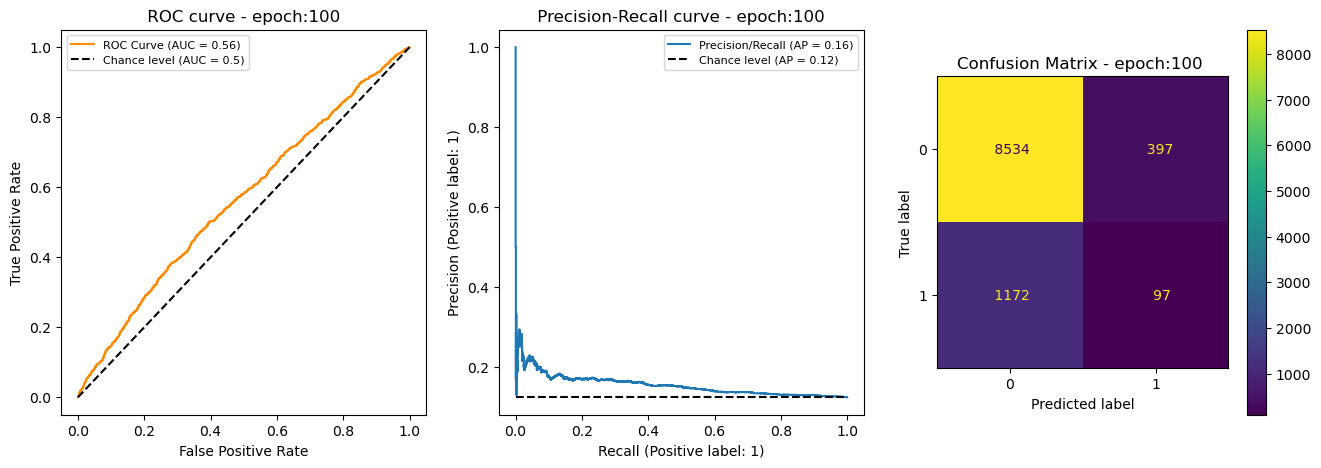

In [31]:
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, epochs = 100 )
mo = compute_classification_metrics(mdl_outputs, True)

 accuracy :   82.92 %
 roc_auc  :   0.555263 
 precision:   0.172891   
 recall   :   0.098503    
 f1       :   0.125502

 Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      8931
           1       0.17      0.10      0.13      1269

    accuracy                           0.83     10200
   macro avg       0.53      0.52      0.52     10200
weighted avg       0.79      0.83      0.81     10200

[9477  723]


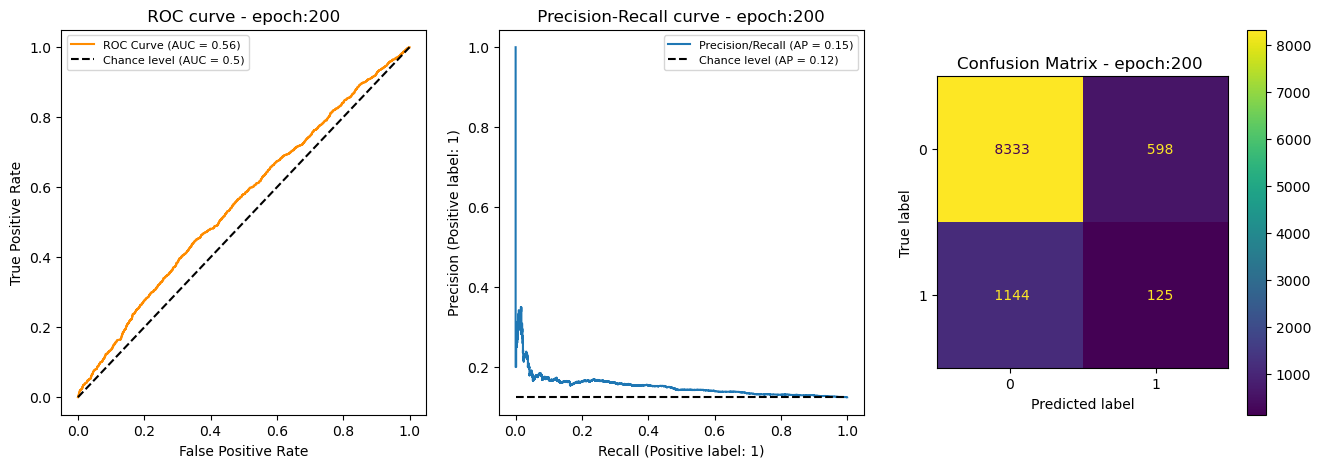

In [39]:
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, epochs = 200 )
mo = compute_classification_metrics(mdl_outputs, True)

 accuracy :   82.83 %
 roc_auc  :   0.551280 
 precision:   0.166205   
 recall   :   0.094563    
 f1       :   0.120542

 Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8931
           1       0.17      0.09      0.12      1269

    accuracy                           0.83     10200
   macro avg       0.52      0.51      0.51     10200
weighted avg       0.79      0.83      0.81     10200

[9478  722]


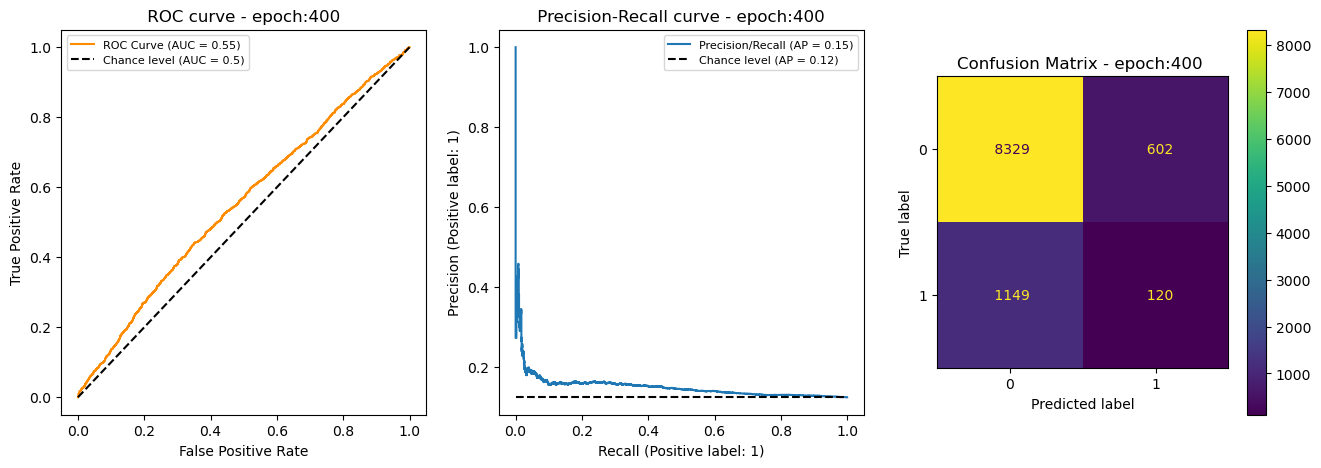

In [50]:
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, epochs = 400 )
mo = compute_classification_metrics(mdl_outputs, True)

 accuracy :   82.37 %
 roc_auc  :   0.551468 
 precision:   0.159588   
 recall   :   0.097715    
 f1       :   0.121212

 Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8931
           1       0.16      0.10      0.12      1269

    accuracy                           0.82     10200
   macro avg       0.52      0.51      0.51     10200
weighted avg       0.79      0.82      0.80     10200

[9423  777]


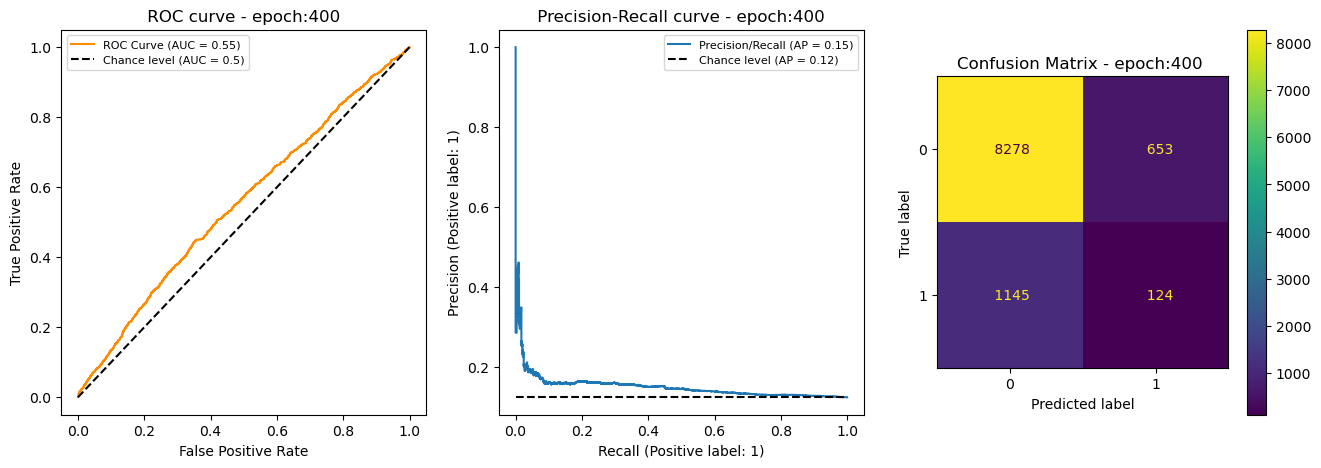

In [56]:
plot_cls_metrics(mdl_outputs.y_true, mdl_outputs.y_prob, mdl_outputs.y_pred, epochs = 400 )
mo = compute_classification_metrics(mdl_outputs, True)

### MinMax TPSA 128 x 64 , no BatchNorm 

**MinMax TPSA 128 x 64 , no BatchNorm**

**50k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.79670     Pearson Coeff. 0.8926

     val   data:        MSE loss:     0.0001    R2 Score: 0.68855     Pearson Coeff. 0.8333

     test  data:        MSE loss:     0.0002    R2 Score: 0.66196     Pearson Coeff. 0.8145


**100k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.88567     Pearson Coeff. 0.9418

     val   data:        MSE loss:     0.0001    R2 Score: 0.70376     Pearson Coeff. 0.8402

     test  data:        MSE loss:     0.0002    R2 Score: 0.70878     Pearson Coeff. 0.8433
      
      
**150k iterations**

     train data:        MSE loss:     0.0001    R2 Score: 0.88960     Pearson Coeff. 0.9438

     val   data:        MSE loss:     0.0001    R2 Score: 0.70221     Pearson Coeff. 0.8394

     test  data:        MSE loss:     0.0002    R2 Score: 0.70636     Pearson Coeff. 0.8420
      
      
**200k iterations**

    train data:        MSE loss:     0.0001    R2 Score: 0.89114     Pearson Coeff. 0.9441

     val   data:       MSE loss:     0.0001    R2 Score: 0.70325     Pearson Coeff. 0.8394

     test  data:       MSE loss:     0.0002    R2 Score: 0.70603     Pearson Coeff. 0.8416
      

**250k iterations**      
      
     train data:        MSE loss:     0.0001    R2 Score: 0.89125     Pearson Coeff. 0.9440

     val   data:        MSE loss:     0.0001    R2 Score: 0.70360     Pearson Coeff. 0.8398

     test  data:        MSE loss:     0.0002    R2 Score: 0.70624     Pearson Coeff. 0.8417  
      

### MinMax TPSA 128 x 64 , With BatchNorm 

**MinMax TPSA 128 x 64 , with BatchNorm**

**50k iterations**

     train data:    MSE loss:     0.0001    R2 Score: 0.80766     Pearson Coeff. 0.8994

     val   data:    MSE loss:     0.0001    R2 Score: 0.66401     Pearson Coeff. 0.8181

     test  data:    MSE loss:     0.0002    R2 Score: 0.68471     Pearson Coeff. 0.8312


**100k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.85963     Pearson Coeff. 0.9295

     val   data:    MSE loss:     0.0001    R2 Score: 0.68456     Pearson Coeff. 0.8308

     test  data:    MSE loss:     0.0002    R2 Score: 0.69034     Pearson Coeff. 0.8358      
      
      
**150k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.87261     Pearson Coeff. 0.9345

     val   data:    MSE loss:     0.0001    R2 Score: 0.69643     Pearson Coeff. 0.8354

     test  data:    MSE loss:     0.0002    R2 Score: 0.69435     Pearson Coeff. 0.8362

      
**200k iterations**


     train data:    MSE loss:     0.0001    R2 Score: 0.87318     Pearson Coeff. 0.9345

     val   data:    MSE loss:     0.0001    R2 Score: 0.69366     Pearson Coeff. 0.8337

     test  data:    MSE loss:     0.0002    R2 Score: 0.69301     Pearson Coeff. 0.8363      
     

**250k iterations**      
      
     train data:    MSE loss:     0.0001    R2 Score: 0.87323     Pearson Coeff. 0.9346

     val   data:    MSE loss:     0.0001    R2 Score: 0.69520     Pearson Coeff. 0.8343

     test  data:    MSE loss:     0.0002    R2 Score: 0.69483     Pearson Coeff. 0.8368
      

In [ ]:
from sklearn.metrics import get_scorer_names
for i in get_scorer_names() :
    if "error" in i:
        print(i)

# Modify TPSA Threshold

In [269]:

train_y_72 = np.zeros_like(train_y)
train_y_72.shape[0]/3

104000.0

In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

df_train.TPSA.count()
df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
_tmp = df_train.Metadata_Permiation.value_counts()
_tmp[0], _tmp[1]

(274836, 37164)

In [264]:
for threshold in [68, 69, 70, 71, 72, 100]:
    _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
    print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
    print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
    print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")


 TPSA threshold 68 
 Total samples: 312000
 Label 0:  138900      % 44.52 
 Label 1:  173100      % 55.48 

 TPSA threshold 69 
 Total samples: 312000
 Label 0:  144249      % 46.23 
 Label 1:  167751      % 53.77 

 TPSA threshold 70 
 Total samples: 312000
 Label 0:  149058      % 47.77 
 Label 1:  162942      % 52.23 

 TPSA threshold 71 
 Total samples: 312000
 Label 0:  154125      % 49.40 
 Label 1:  157875      % 50.60 

 TPSA threshold 72 
 Total samples: 312000
 Label 0:  160203      % 51.35 
 Label 1:  151797      % 48.65 

 TPSA threshold 100 
 Total samples: 312000
 Label 0:  274836      % 88.09 
 Label 1:   37164      % 11.91 


In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


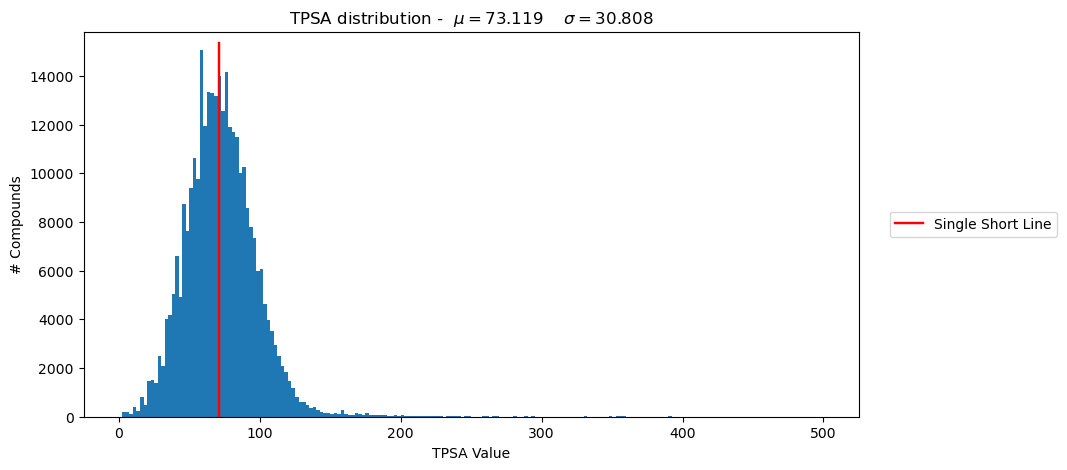

In [259]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 200
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,5))
sigma = df_train.Metadata_TPSA.std()
mu = df_train.Metadata_TPSA.mean()
med = df_train.Metadata_TPSA.median()
# the histogram of the data
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# p1 = [(med, 710), (6.0, 605)]
# _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
_ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
_ = plt.xlabel('TPSA Value');
_ = plt.ylabel('# Compounds');
_ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# axs[1].hist(dist2, bins=n_bins)
plt.show()

# Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

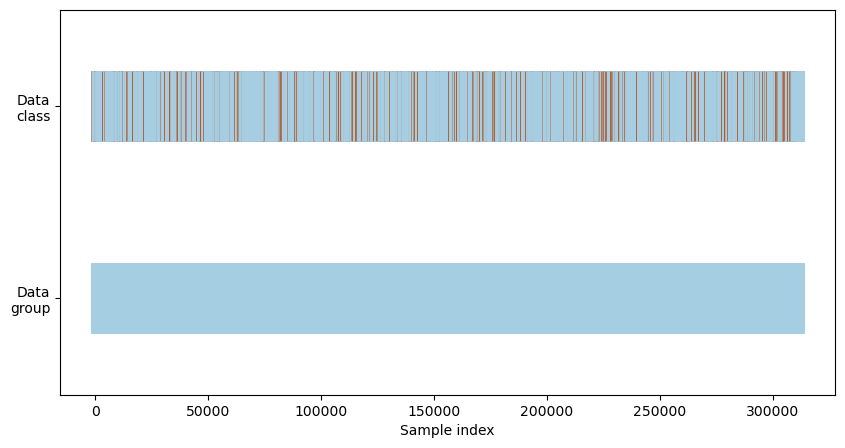

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

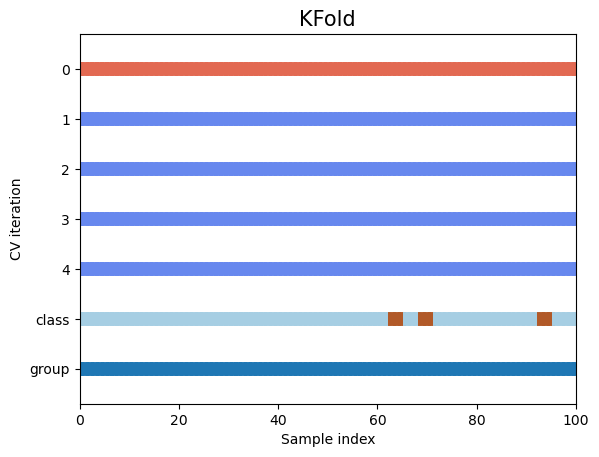

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

# Input 

## Read Embedded Features CSV file

In [11]:
BASE_TRAIN_INPUT = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = BASE_runmode ,datatype='train'))
BASE_TEST_INPUT  = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = BASE_runmode ,datatype='test'))
SNNL_TRAIN_INPUT = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='train'))
SNNL_TEST_INPUT  = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='test'))
BASE_TRAIN_INPUT
BASE_TEST_INPUT 
SNNL_TRAIN_INPUT
SNNL_TEST_INPUT 

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'

In [12]:
df_test = pd.read_csv(SNNL_TEST_INPUT )
df_train = pd.read_csv(SNNL_TRAIN_INPUT)

# df_train = pd.read_csv(BASE_TRAIN_INPUT)
# df_test = pd.read_csv(BASE_TEST_INPUT )
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [13]:
df_test.info()
df_test.shape
df_test.columns
df_test.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 42.4+ MB


(34542, 161)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_140', 'Feature_141', 'Feature_142', 'Feature_143', 'Feature_144', 'Feature_145', 'Feature_146', 'Feature_147',
       'Feature_148', 'Feature_149'],
      dtype='object', length=161)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_11,Batch2,EC000046,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.613709,0.704578
1,source_11,Batch2,EC000063,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.396030,1.886775
2,source_9,20211013-Run14,GR00003281,J15,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.967456,-0.243835
3,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,J10,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,-0.355203,0.057036
4,source_11,Batch3,EC000139,G04,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,1.246175,0.795314


In [14]:
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [15]:
test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
test_y.sum()
test_y.shape, type(test_y), test_y.dtype
test_X = df_test.iloc[:,11:].to_numpy()
test_X.shape,type(test_X), test_X.dtype

4164

((34542,), numpy.ndarray, dtype('uint8'))

((34542, 150), numpy.ndarray, dtype('float64'))

In [19]:
df_train.shape
df_train.info()
df_train.iloc[:5,:16]

(312000, 161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312000 entries, 0 to 311999
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 383.2+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,-0.584816,1.739848,-0.512839,0.171693,-0.277947
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.072229,4.545980,-0.728832,-6.005501,0.926439
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,1.418385,4.461677,2.481470,-0.635005,-2.307799
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,-2.747379,0.744657,2.082911,1.504725,1.156345
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,0.559964,1.732896,0.296971,-1.477167,1.171373


In [20]:
312000+34542

346542

In [21]:
train_y = df_train.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
train_y.sum()
train_y.shape, type(train_y), train_y.dtype

train_X = df_train.iloc[:,11:].to_numpy()
train_X.shape,type(train_X) ,train_X.dtype

37164

((312000,), numpy.ndarray, dtype('uint8'))

((312000, 150), numpy.ndarray, dtype('float64'))

## Standardize inputs

In [22]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [23]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [24]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [25]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [26]:
label_counts([("Training", train_y), ("Test", test_y)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



# TQDM Examples

In [322]:
#-----------------------------------------
# TRANGE example
#-----------------------------------------   
# with trange(+1, ns.trn_iters_warmup+1 , initial = 0 , total = ns.trn_iters_warmup, position=0, file=sys.stdout,
#             leave= False, disable = disable_tqdm, desc=f" Warmup Epoch {ns.current_epoch}/{ns.stop_epoch_warmup}") as t_warmup :
#     for _ in t_warmup:
#         ns.current_iter += 1            

#         batch = next(dldrs.warmup_trn_loader)            
#         environ.set_inputs(batch, input_size)

#         environ.optimize(is_policy=False, 
#                          num_train_layers=ns.num_train_layers,
#                          flag='update_weights', 
#                          verbose = verbose)
    
#         t_warmup.set_postfix({'curr_iter':ns.current_iter, 
#                             'Loss': f"{environ.losses['total']['total'].item():.4f}"})

#-----------------------------------------
# TQDM example
#-----------------------------------------   
# current_epoch = 1
# total_epochs = 20
# current_iter = 0 
# train_minibatches = len(data_loader['train']) // minibatch_size
# val_minibatches = len(data_loader['val']) // minibatch_size

# # with batch_count, (batch_features, batch_labels, _, _, _, _) in tqdm(enumerate(data_loader['train']), initial=0, total = 400, position=0, file=sys.stdout,
#             # leave= False, desc=f" Epoch {current_epoch}/{total_epochs}") as t_warmup :
# t_warmup =  tqdm(enumerate(data_loader['train']), initial=0, total = train_minibatches, position=0, file=sys.stdout,
#             leave= False, desc=f" Epoch {current_epoch}/{total_epochs}") 
# for batch_count, (batch_features, batch_labels, _, _, _, _) in t_warmup:
#     # batch_count, (batch_features, batch_labels, _, _, _, _) = pp
#     loss = random.random()
#     t_warmup.set_postfix({'curr_iter':batch_count, 'Loss': f"{loss:.4f}"})